In [49]:
import pandas as pd
import numpy as np
import math

from datetime import datetime, timedelta
from datetime import datetime, timezone
from dateutil.tz import tzutc, tzlocal

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from scipy import stats

# Functions for reading files

In [50]:
#the function that chris made to deal with the otl file from wms
def process_otl_file(StartDate, OutletFile):
    
    #example start date: "2018-08-23 00:00"

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "WMS_cms"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("date", inplace=True)
    
    return OutHydro

#combine the observed and modeled streamflow into a clean dataframe for further analysis
def Combo_Obs_Mod_df(Start_Date_Time, GSSHA_streamflow_otl_file, Observed_streamflow_file ='Hanalei_stream_16103000_HAWAII-TIME.csv'):
   # 15 min resampled data: hanalei_stream15min_resampling.csv
    #1 min data 'Hanalei_stream_16103000_HAWAII-TIME.csv'

    #read otl GSSHA file
    df_mod = process_otl_file(Start_Date_Time, GSSHA_streamflow_otl_file)
    
    #read streamflow file
    df_obs = pd.read_csv(Observed_streamflow_file)
    df_obs = df_obs[['datetime', 'metric_discharge_cms' ]].copy()
    df_obs =  df_obs.set_index('datetime')
    df_obs.index = pd.to_datetime(df_obs.index)
    
    #merge the observed streamflow to the modeled streamflow on the date index
    merged = pd.merge(df_mod, df_obs, how = 'inner', left_index = True, right_index = True)
    
    return [merged, Start_Date_Time]

# Function for plotting

In [51]:
def plot_it(merged_dataframe):
    
    #creat subplot
    fig, ax = plt.subplots(figsize=(7,4))

    #make the dates look diagonal and pretty
    fig.autofmt_xdate()

    #convert to standard units
    merged_dataframe['WMS_cms'] = merged_dataframe['WMS_cms'] * 35.314666212661
    merged_dataframe['metric_discharge_cms'] = merged_dataframe['metric_discharge_cms'] * 35.314666212661
    
    #create two plots the ',' is for used on the legend
    a, = ax.plot(merged_dataframe.index, merged_dataframe['WMS_cms'], '--', linewidth = 1, alpha=0.72, zorder=2) #marker ='.', c='lime', edgecolor='black', linewidth = 0.5, s=40)
    b, = ax.plot(merged_dataframe.index, merged_dataframe['metric_discharge_cms'], linewidth = 2, zorder = 1)

    #create a pretty grid
    plt.rc('axes', axisbelow=True)
    ax.grid(True, color='gray', linestyle='dashed', alpha = 0.35)

    #set x axis to margins and y axis to 0-650
    ax.margins(x=0)
    ax.set_ylim([0, 650])

    #add legend, lebels, and text
    ax.legend([a, b], ['Modeled','Observed'])
    ax.set_title('Observed vs. Modeled Streamflow', fontweight="bold")
    ax.set_xlabel('Date (Month/Day/Year)')
    ax.set_ylabel('streamflow (ft$^3$/s)')
    #ax.text(0.023, 0.78, '\nRMSE: ' + str(rmse) + '\nNSE: ' + str(nse), size=9, ha="left", 
             #transform=ax.transAxes,
           #bbox=dict(facecolor='white'))
    ax.set_ylim(0, merged_dataframe['metric_discharge_cms'].max() + 2000)

    #configure datetime axis
    myFmt = DateFormatter("%m-%d-%y")
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    ax.xaxis.set_major_locator(mdates.DayLocator())

    #save figure
    #plt.savefig('AGU.png')
    
    return (ax)

# Function for validation model statistics

What Stats?
RMSE, NSE, PBIAS, Timing of Streamflow Peak error, Peak Streamflow Percent Error

In [52]:
def RMSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    n = len(Oi)
    
    RMSE = math.sqrt( np.sum( (Oi - Pi)**2 ) / n  )
    return round(RMSE, 2)

def PBIAS(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    
    PBIAS = (( np.sum(Oi - Pi) ) / np.sum(Oi))*100
    return round(PBIAS, 2)

def NSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    O_bar = np.mean(Oi)
    
    NSE = 1 - ( np.sum( (Oi - Pi)**2 )  /  np.sum( (Oi - O_bar)**2 ) )
    return round(NSE, 2)

def max_streamflow_percent_error(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    Oi_max = np.max(Oi)
    Pi_max = np.max(Pi)
    
    PE = (( Pi_max - Oi_max) / Oi_max)*100
    return round(PE, 2)

def max_streamflow_timing_difference(merged_dataframe):
    Oi = list(merged_dataframe.metric_discharge_cms)
    Pi = list(merged_dataframe.WMS_cms)
    Oi_max = max(Oi)
    Pi_max = max(Pi)
    Oi_max_index = Oi.index(Oi_max)
    Pi_max_index = Pi.index(Pi_max)
    
    date_time = merged_dataframe.index
    Oi_max_time = date_time[Oi_max_index]
    Pi_max_time = date_time[Pi_max_index]
    
    time_dif = (Pi_max_time - Oi_max_time) / pd.Timedelta(hours = 1)
    return round(time_dif, 2)

def KSE(merged_dataframe):
    Oi = np.array(list(merged_dataframe.metric_discharge_cms))
    Pi = np.array(list(merged_dataframe.WMS_cms))
    O_std = np.std(Oi)
    P_std = np.std(Pi)
    O_mean = np.mean(Oi)
    P_mean = np.mean(Pi)
    r = stats.pearsonr(Oi, Pi)[0]
    KSE = 1 - math.sqrt((r-1)**2 + ((P_std/O_std) - 1)**2 + (P_mean / O_mean)**2)
    return round(KSE, 2)
    
    
def GET_STATS(merged_dataframe_start_datetime_list):
    compiled_df = []
    for i in merged_dataframe_start_datetime_list: 
        merged_dataframe = i[0]
        Start_date_time = i[1]

        RMSE_stat = RMSE(merged_dataframe)
        NSE_stat = NSE(merged_dataframe)
        PBIAS_stat = PBIAS(merged_dataframe)
        PE_maxstreamflow = max_streamflow_percent_error(merged_dataframe)
        E_maxstreamflow = max_streamflow_timing_difference(merged_dataframe)
        KSE_stat = KSE(merged_dataframe)


        STATS_dict = {'RMSE' : RMSE_stat , 'NSE' : NSE_stat, 'KSE': KSE_stat, 'PBIAS' : PBIAS_stat, 'Percent Error of Max Streamflow' : PE_maxstreamflow, 'Max Streamflow time difference' : E_maxstreamflow }
        df = pd.DataFrame(STATS_dict, index= [Start_date_time])
        compiled_df.append(df)
    result = pd.concat(compiled_df)
    return result

# Code for resampling the streamflow to 15 mins, not really needed but kept for future usage


In [53]:
# hanalei_stream15min = pd.read_csv('Hanalei_stream_16103000_HAWAII-TIME.csv')
# hanalei_stream15min = hanalei_stream15min[['datetime', 'metric_discharge_cms']]

# #to date time
# hanalei_stream15min['datetime'] = pd.to_datetime(hanalei_stream15min['datetime'])

# # Set the index of the DataFrame to the time column
# hanalei_stream15min.set_index('datetime', inplace=True)

# # Resample the DataFrame to weekly data using the maximum value of each week
# hanalei_stream15min_resampled = hanalei_stream15min.resample('15min').apply(np.nanmean)

# hanalei_stream15min_resampled.to_csv('hanalei_stream15min_resampling.csv')

# Compare infiltration to no infiltration for calibration purposes

In [54]:
df_roughness_only = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-06 00:00', GSSHA_streamflow_otl_file = '30m_ROUGHNESS_ONLY_050611.otl')
df_GA_single_layer = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-06 00:00', GSSHA_streamflow_otl_file = '30m_SINGLE_LAYER_INFILTRATION_050611.otl')
df_GA_multi_layer = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-06 00:00', GSSHA_streamflow_otl_file = '30m_MULTI_LAYER_INFILTRATION_050611.otl')

C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)


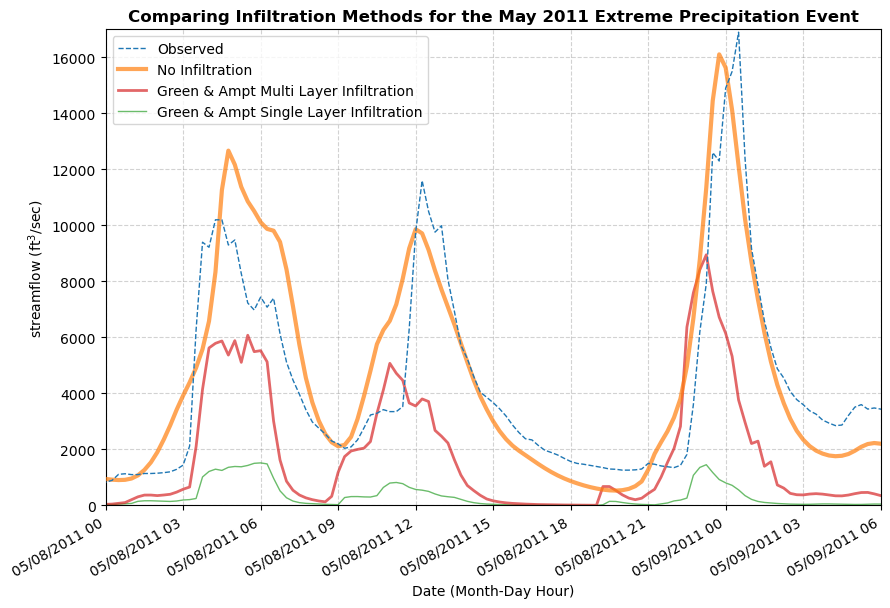

In [55]:
#creat subplot
fig, ax = plt.subplots(figsize=(10,7))

#make the dates look diagonal and pretty
fig.autofmt_xdate()

#create two plots the ',' is for used on the legend
a, = ax.plot(df_roughness_only[0].index, df_roughness_only[0]['metric_discharge_cms'] * 35.314666212661, linewidth = 1,linestyle = '--', zorder = 4, alpha = 1)
b, = ax.plot(df_roughness_only[0].index, df_roughness_only[0]['WMS_cms'] * 35.314666212661, linewidth = 3, zorder = 3, alpha = 0.7) #marker ='.', c='lime', edgecolor='black', linewidth = 0.5, s=40)
c, = ax.plot(df_roughness_only[0].index, df_GA_single_layer[0]['WMS_cms'] * 35.314666212661, linewidth = 1, zorder = 1, alpha = 0.7)
d, = ax.plot(df_roughness_only[0].index, df_GA_multi_layer[0]['WMS_cms'] * 35.314666212661, linewidth = 2, zorder = 2, alpha = 0.7)


#create a pretty grid
plt.rc('axes', axisbelow=True)
ax.grid(True, color='gray', linestyle='dashed', alpha = 0.35)

#set x axis to margins and y axis to 0-650
ax.margins(x=0)
ax.set_ylim([0, 650])

#add legend, lebels, and text
ax.legend([a, b, d, c], ['Observed','No Infiltration', 'Green & Ampt Multi Layer Infiltration', 'Green & Ampt Single Layer Infiltration'])
ax.set_title('Comparing Infiltration Methods for the May 2011 Extreme Precipitation Event', fontweight="bold")
ax.set_xlabel('Date (Month-Day Hour)')
ax.set_ylabel('streamflow (ft$^3$/sec)')
#ax.text(0.023, 0.78, '\nRMSE: ' + str(rmse) + '\nNSE: ' + str(nse), size=9, ha="left", 
         #transform=ax.transAxes,
       #bbox=dict(facecolor='white'))
ax.set_ylim(0, (df_roughness_only[0]['metric_discharge_cms'] * 35.314666212661).max() +100)
ax.set_xlim(pd.to_datetime('05-08-2011'), pd.to_datetime('05-9-2011 6:00'))

#configure datetime axis

hours = mdates.HourLocator(interval = 1)
myFmt = DateFormatter("%m-%d-%y %H")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H'))
#ax.xaxis.set_major_locator(mdates.DayLocator())

#save figure
#plt.savefig('Comparing_Infiltration_methods.png')



# Model performance w/ 60m grid size, uncalibrated and no radar usage

C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option

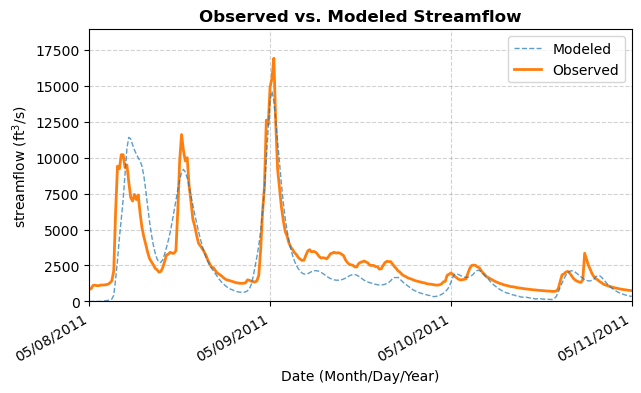

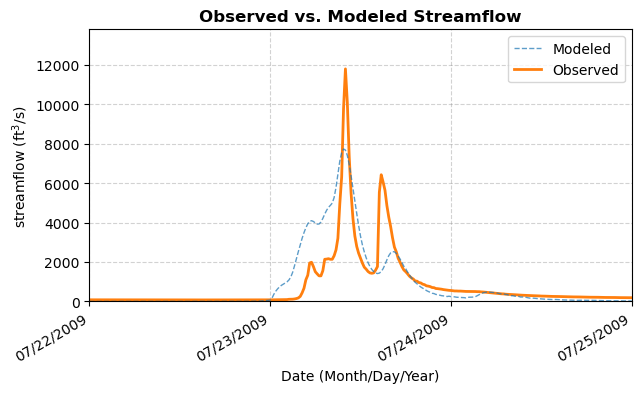

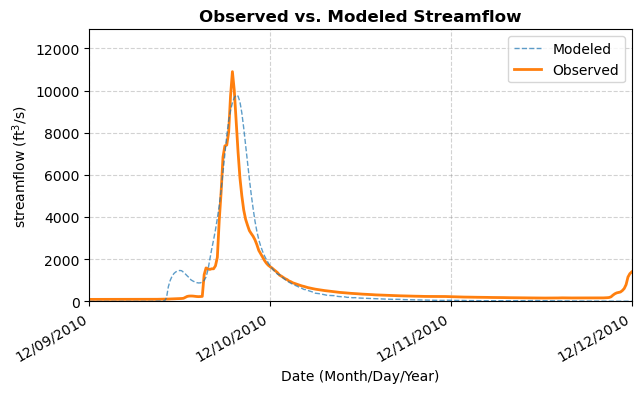

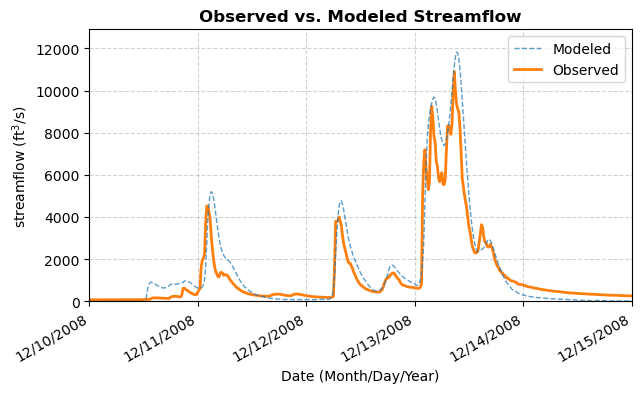

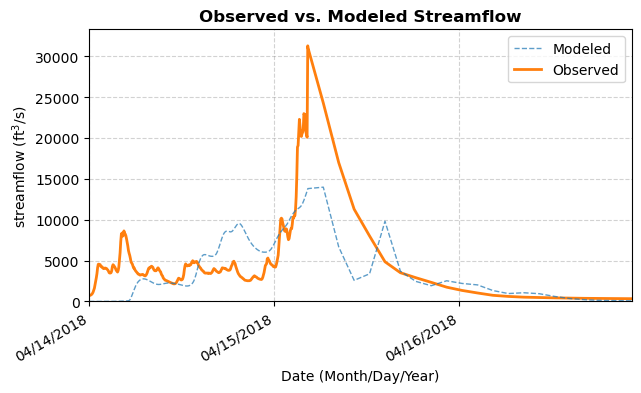

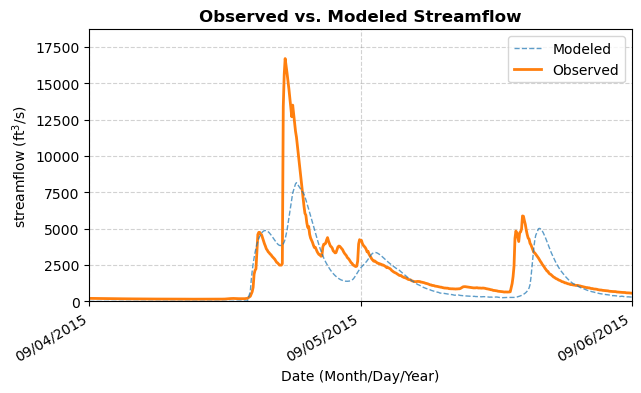

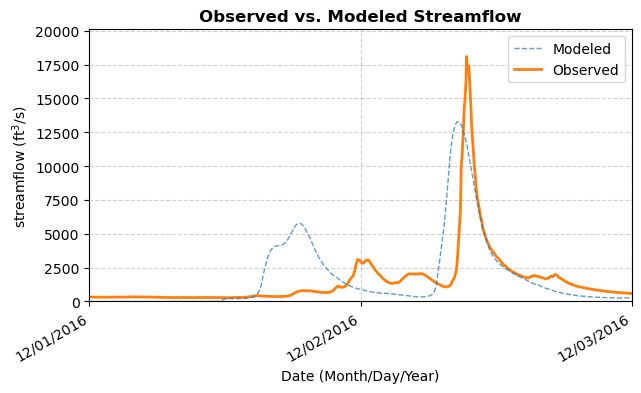

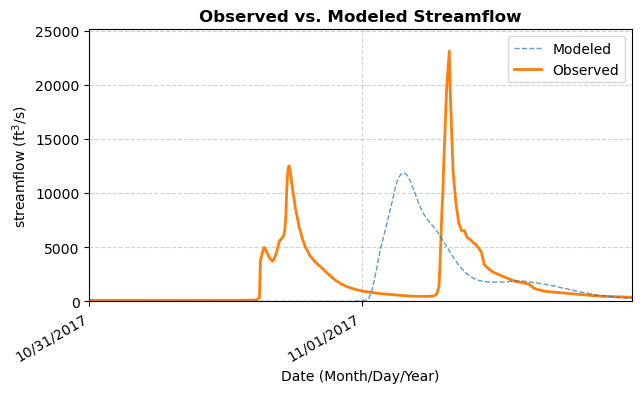

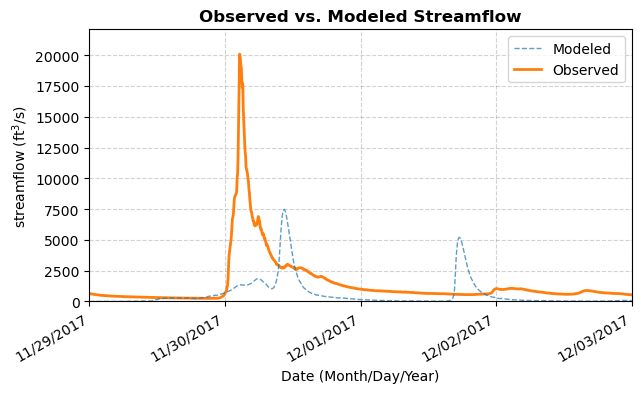

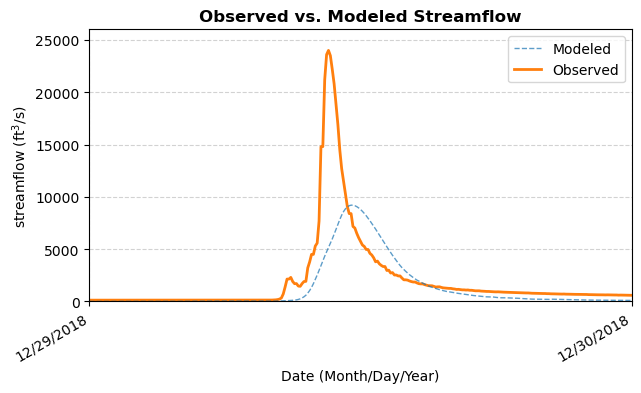

In [56]:
#all files with no radar and regular EG LU roughness  = 0.11

df_050811 = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-08 00:00', GSSHA_streamflow_otl_file = '30m_EG011_050811.otl')
df_072209 = Combo_Obs_Mod_df(Start_Date_Time = '2009-07-22 00:00', GSSHA_streamflow_otl_file = '30m_EG011_072209.otl')
df_120910 = Combo_Obs_Mod_df(Start_Date_Time = '2010-12-09 00:00', GSSHA_streamflow_otl_file = '30m_EG011_120910.otl')
df_121008 = Combo_Obs_Mod_df(Start_Date_Time = '2008-12-10 00:00', GSSHA_streamflow_otl_file = '30m_EG011_121008.otl')
df_041418 = Combo_Obs_Mod_df(Start_Date_Time = '2018-04-14 00:00', GSSHA_streamflow_otl_file = '30m_EG011_041418.otl')
df_090415 = Combo_Obs_Mod_df(Start_Date_Time = '2015-09-04 00:00', GSSHA_streamflow_otl_file = '30m_EG011_090415.otl')
df_120116 = Combo_Obs_Mod_df(Start_Date_Time = '2016-12-01 00:00', GSSHA_streamflow_otl_file = '30m_EG011_103117.otl')
df_103117 = Combo_Obs_Mod_df(Start_Date_Time = '2017-10-31 00:00', GSSHA_streamflow_otl_file = '30m_EG011_112917.otl')
df_112917 = Combo_Obs_Mod_df(Start_Date_Time = '2017-11-29 00:00', GSSHA_streamflow_otl_file = '30m_EG011_120116.otl')
df_122918 = Combo_Obs_Mod_df(Start_Date_Time = '2018-12-29 00:00', GSSHA_streamflow_otl_file = '30m_EG011_122918.otl')



obs_mod_list = [df_050811, df_072209, df_120910, df_121008, df_041418, df_090415, df_120116, df_103117, df_112917, df_122918]

for i in obs_mod_list:
    plot_it(i[0])

In [57]:
#get stats of no radar model performance

all_stats = GET_STATS(obs_mod_list)
all_stats.index = pd.to_datetime(all_stats.index)
all_stats  = all_stats.reset_index()
all_stats = all_stats.sort_values(by = 'index').reset_index(drop=True)
#all_stats.to_csv('all_stats.csv')

all_stats

index     RMSE   NSE   KSE  PBIAS  Percent Error of Max Streamflow  \
0 2008-12-10   848.21  0.82 -0.18 -15.54                             8.54   
1 2009-07-22  1036.69  0.56 -0.13 -10.86                           -34.44   
2 2010-12-09   672.65  0.83 -0.08  -5.77                           -10.21   
3 2011-05-08  1333.44  0.76  0.11  11.85                           -13.62   
4 2015-09-04  1715.51  0.42  0.10  19.34                           -51.08   
5 2016-12-01  2422.14  0.08 -0.25 -18.17                           -26.59   
6 2017-10-31  5159.18 -1.28 -0.43   8.63                           -48.71   
7 2017-11-29  2563.07 -0.08  0.03  59.49                           -62.77   
8 2018-04-14  3962.84  0.22 -0.02   9.78                           -55.29   
9 2018-12-29  3027.45  0.44  0.17  34.17                           -61.64   

   Max Streamflow time difference  
0                            0.50  
1                           -0.25  
2                            0.50  
3                           -0.25  
4                            1.00  
5                           -0.80  
6                           -3.98  
7                            7.88  
8                            2.02  
9                            1.00

# Compare model performance w/ RADAR VS NO RADAR

In [58]:
df_041418_noradar = Combo_Obs_Mod_df(Start_Date_Time = '2018-04-14 00:00', GSSHA_streamflow_otl_file = '30m_noradar_041418.otl')
df_041418_radar = Combo_Obs_Mod_df(Start_Date_Time = '2018-04-14 00:00', GSSHA_streamflow_otl_file = '30m_radar_041418.otl')

df_103117_noradar = Combo_Obs_Mod_df(Start_Date_Time = '2017-10-31 00:00', GSSHA_streamflow_otl_file = '30m_noradar_103117.otl')
df_103117_radar = Combo_Obs_Mod_df(Start_Date_Time = '2017-10-31 00:00', GSSHA_streamflow_otl_file = '30m_radar_103117.otl')

df_112917_noradar = Combo_Obs_Mod_df(Start_Date_Time = '2017-11-29 00:00', GSSHA_streamflow_otl_file = '30m_noradar_112917.otl')
df_112917_radar = Combo_Obs_Mod_df(Start_Date_Time = '2017-11-29 00:00', GSSHA_streamflow_otl_file = '30m_radar_112917.otl')

df_122918_noradar = Combo_Obs_Mod_df(Start_Date_Time = '2018-12-29 00:00', GSSHA_streamflow_otl_file = '30m_noradar_122918.otl')
df_122918_radar = Combo_Obs_Mod_df(Start_Date_Time = '2018-12-29 00:00', GSSHA_streamflow_otl_file = '30m_radar_122918.otl')

radar_compare = [df_041418_radar, df_041418_noradar, df_103117_radar, df_103117_noradar, df_112917_radar, df_112917_noradar, df_122918_radar, df_122918_noradar]

C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option

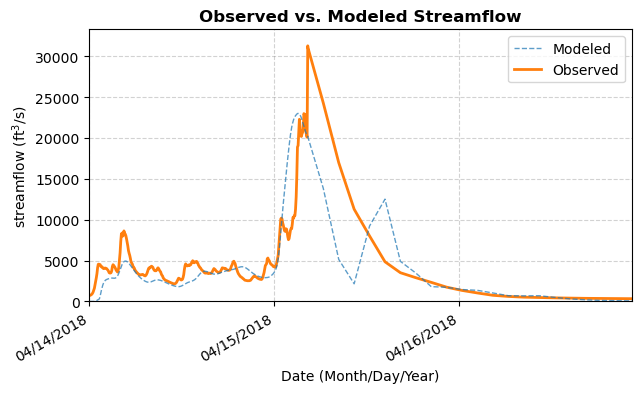

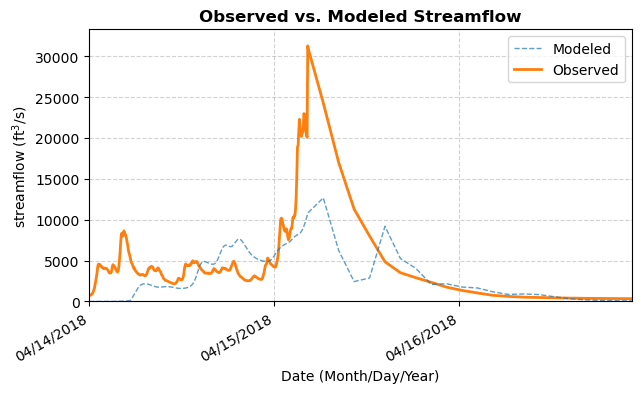

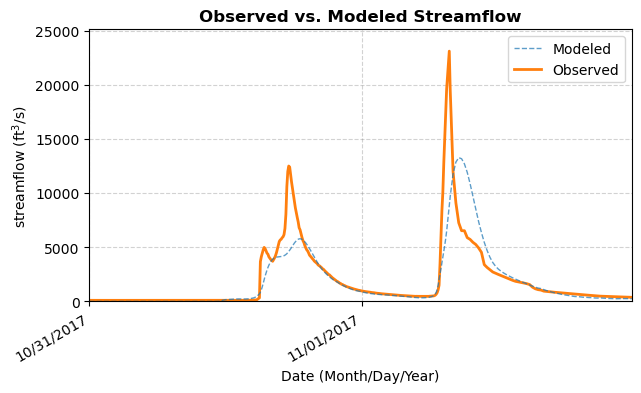

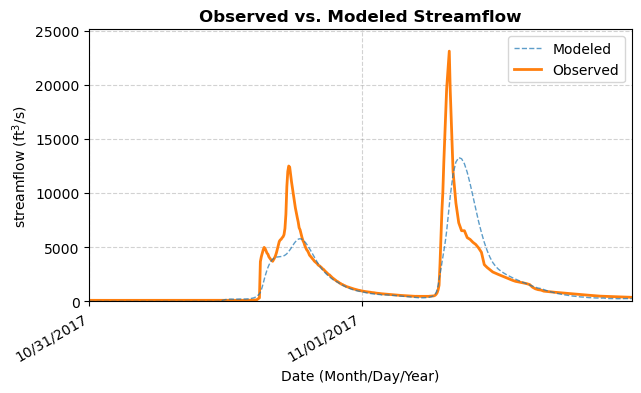

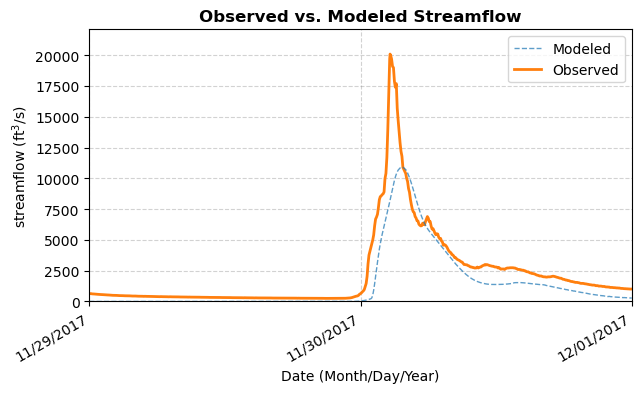

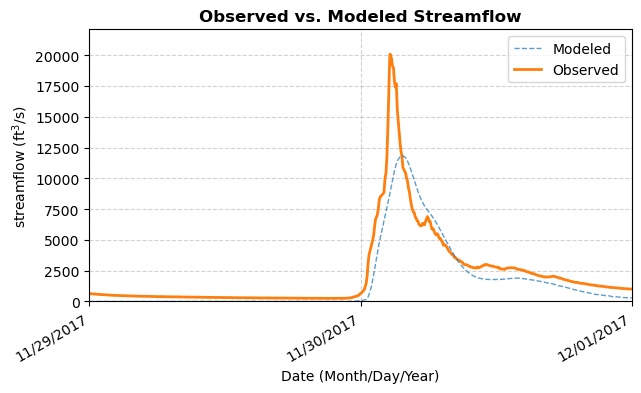

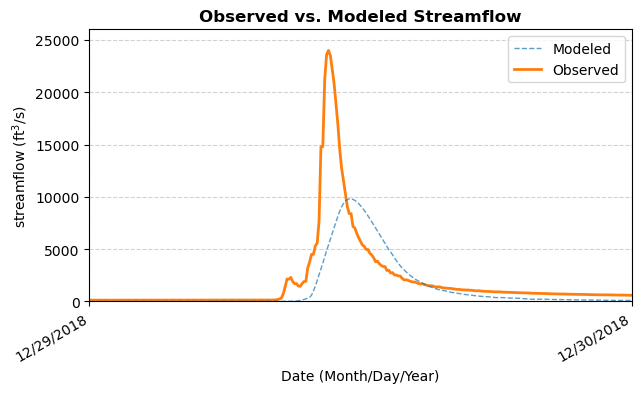

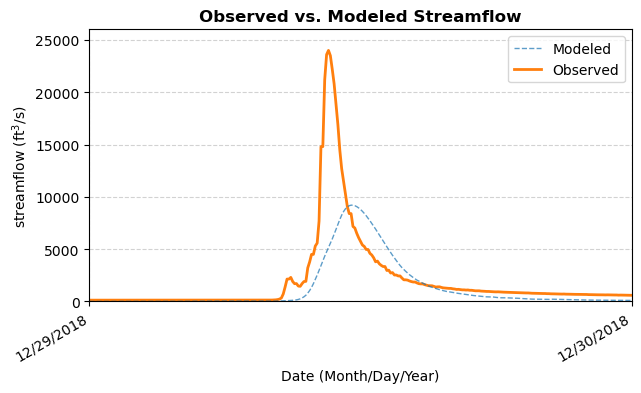

In [59]:
#first plot is radar, second plot is no radar
for i in radar_compare:
    plot_it(i[0])


In [60]:
radar_compare_stats = GET_STATS(radar_compare)
radar_compare_stats.index = pd.to_datetime(radar_compare_stats.index)
radar_compare_stats  = radar_compare_stats.reset_index()
radar_compare_stats = radar_compare_stats.sort_values(by = 'index').reset_index(drop=True)
#all_stats.to_csv('all_stats.csv')

radar_compare_stats['radar_noradar'] = ['radar', 'no radar', 'radar', 'no radar', 'radar', 'no radar', 'radar', 'no radar']
radar_compare_stats

index     RMSE   NSE   KSE  PBIAS  Percent Error of Max Streamflow  \
0 2017-10-31  2218.45  0.58  0.12  18.86                           -42.55   
1 2017-10-31  2218.53  0.58  0.12  18.86                           -42.53   
2 2017-11-29  1712.61  0.74  0.32  37.62                           -45.71   
3 2017-11-29  1576.83  0.78  0.25  27.24                           -41.06   
4 2018-04-14  3134.41  0.51 -0.01   3.49                           -26.44   
5 2018-04-14  4106.35  0.16  0.07  28.01                           -59.47   
6 2018-12-29  3006.43  0.44  0.18  33.35                           -59.11   
7 2018-12-29  3027.45  0.44  0.17  34.17                           -61.64   

   Max Streamflow time difference radar_noradar  
0                            0.83         radar  
1                            0.83      no radar  
2                            1.05         radar  
3                            1.13      no radar  
4                           -1.25         radar  
5                            2.02      no radar  
6                            1.00         radar  
7                            1.00      no radar

# Calibration time. Looking at Evergreen forest LU roughness values (0.11, 0.047, and 0.4

## table of the original Land USE EG stats with roughness = 0.11 !!some have radar included!! see above for which dates have radar available for model usage

In [61]:
#list the original EG files
orginal_EG = [df_050811, df_072209, df_120910, df_121008, df_041418_radar, df_090415, df_120116, df_103117_radar, df_112917_radar, df_122918_radar]

#collect stats
OG_EG_stats = GET_STATS(orginal_EG)
OG_EG_stats.index = pd.to_datetime(OG_EG_stats.index)
OG_EG_stats  = OG_EG_stats.reset_index()
OG_EG_stats = OG_EG_stats.sort_values(by = 'index').reset_index(drop=True)
OG_EG_stats['LU_EG_ROUGH'] = 0.11
#OG_EG_stats.to_csv('OG_EG_stats.csv')

OG_EG_stats

index     RMSE   NSE   KSE  PBIAS  Percent Error of Max Streamflow  \
0 2008-12-10   848.21  0.82 -0.18 -15.54                             8.54   
1 2009-07-22  1036.69  0.56 -0.13 -10.86                           -34.44   
2 2010-12-09   672.65  0.83 -0.08  -5.77                           -10.21   
3 2011-05-08  1333.44  0.76  0.11  11.85                           -13.62   
4 2015-09-04  1715.51  0.42  0.10  19.34                           -51.08   
5 2016-12-01  2422.14  0.08 -0.25 -18.17                           -26.59   
6 2017-10-31  2218.45  0.58  0.12  18.86                           -42.55   
7 2017-11-29  1712.61  0.74  0.32  37.62                           -45.71   
8 2018-04-14  3134.41  0.51 -0.01   3.49                           -26.44   
9 2018-12-29  3006.43  0.44  0.18  33.35                           -59.11   

   Max Streamflow time difference  LU_EG_ROUGH  
0                            0.50         0.11  
1                           -0.25         0.11  
2                            0.50         0.11  
3                           -0.25         0.11  
4                            1.00         0.11  
5                           -0.80         0.11  
6                            0.83         0.11  
7                            1.05         0.11  
8                           -1.25         0.11  
9                            1.00         0.11

## Table of the minimum LU EG values (roughness  = 0.047)

In [62]:
#read in all the min files
df_050811_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-08 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_050811.otl')
df_072209_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2009-07-22 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_072209.otl')
df_120910_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2010-12-09 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_120910.otl')
df_121008_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2008-12-10 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_121008.otl')
df_041418_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2018-04-14 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_041418.otl')
df_090415_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2015-09-04 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_090415.otl')
df_120116_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2016-12-01 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_120116.otl')
df_103117_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2017-10-31 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_103117.otl')
df_112917_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2017-11-29 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_112917.otl')
df_122918_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2018-12-29 00:00', GSSHA_streamflow_otl_file = '30m_EG0047_122918.otl')

#create a list of all the dataframes
min_EG_calibtest = [df_050811_minEG, df_072209_minEG, df_120910_minEG, df_121008_minEG, df_041418_minEG, df_090415_minEG, df_120116_minEG, df_103117_minEG, df_112917_minEG, df_122918_minEG]

C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option

In [63]:
#collect stats
min_EG_stats = GET_STATS(min_EG_calibtest)
min_EG_stats.index = pd.to_datetime(min_EG_stats.index)
min_EG_stats  = min_EG_stats.reset_index()
min_EG_stats = min_EG_stats.sort_values(by = 'index').reset_index(drop=True)
min_EG_stats['LU_EG_ROUGH'] = 0.05
#min_EG_stats.to_csv('minEG_stats.csv')

min_EG_stats

index   RMSE   NSE   KSE  PBIAS  Percent Error of Max Streamflow  \
0 2008-12-10  21.48  0.86 -0.19 -15.67                            10.27   
1 2009-07-22  31.68  0.56 -0.11  -8.92                           -29.98   
2 2010-12-09  24.92  0.85 -0.15 -13.32                           -19.84   
3 2011-05-08  37.50  0.76  0.10  11.54                           -19.69   
4 2015-09-04  43.45  0.53  0.16  21.38                           -47.75   
5 2016-12-01  39.50  0.56  0.37  50.53                           -54.26   
6 2017-10-31  55.22  0.67  0.19  27.01                           -47.69   
7 2017-11-29  38.45  0.83  0.33  36.74                           -42.53   
8 2018-04-14  96.79  0.42 -0.07  -1.36                           -25.25   
9 2018-12-29  61.28  0.71  0.26  32.53                           -53.23   

   Max Streamflow time difference  LU_EG_ROUGH  
0                            0.25         0.05  
1                           -0.47         0.05  
2                            0.45         0.05  
3                           -0.65         0.05  
4                            0.58         0.05  
5                            0.62         0.05  
6                            0.58         0.05  
7                            0.72         0.05  
8                           -1.58         0.05  
9                            0.42         0.05

## Table of the maximum LU EG values (roughness  = 0.4)

In [64]:
#read in all the min files
df_050811_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2011-05-08 00:00', GSSHA_streamflow_otl_file = '30m_EG04_050811.otl')
df_072209_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2009-07-22 00:00', GSSHA_streamflow_otl_file = '30m_EG04_072209.otl')
df_120910_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2010-12-09 00:00', GSSHA_streamflow_otl_file = '30m_EG04_120910.otl')
df_121008_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2008-12-10 00:00', GSSHA_streamflow_otl_file = '30m_EG04_121008.otl')
df_041418_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2018-04-14 00:00', GSSHA_streamflow_otl_file = '30m_EG04_041418.otl')
df_090415_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2015-09-04 00:00', GSSHA_streamflow_otl_file = '30m_EG04_090415.otl')
df_120116_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2016-12-01 00:00', GSSHA_streamflow_otl_file = '30m_EG04_120116.otl')
df_103117_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2017-10-31 00:00', GSSHA_streamflow_otl_file = '30m_EG04_103117.otl')
df_112917_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2017-11-29 00:00', GSSHA_streamflow_otl_file = '30m_EG04_112917.otl')
df_122918_maxEG = Combo_Obs_Mod_df(Start_Date_Time = '2018-12-29 00:00', GSSHA_streamflow_otl_file = '30m_EG04_122918.otl')

#create a list of all the dataframes
max_EG_calibtest = [df_050811_maxEG, df_072209_maxEG, df_120910_maxEG, df_121008_maxEG, df_041418_maxEG, df_090415_maxEG, df_120116_maxEG, df_103117_maxEG, df_112917_maxEG, df_122918_maxEG]

C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_obs = pd.read_csv(Observed_streamflow_file)
C:\Users\bgorb\AppData\Local\Temp\ipykernel_12540\3212333444.py:29: DtypeWarning: Columns (7) have mixed types. Specify dtype option

In [65]:
#collect stats
max_EG_stats = GET_STATS(max_EG_calibtest)
max_EG_stats.index = pd.to_datetime(max_EG_stats.index)
max_EG_stats  = max_EG_stats.reset_index()
max_EG_stats = max_EG_stats.sort_values(by = 'index').reset_index(drop=True)
max_EG_stats['LU_EG_ROUGH'] = 0.4
max_EG_stats.to_csv('max_EG_stats.csv')

max_EG_stats

index    RMSE   NSE   KSE  PBIAS  Percent Error of Max Streamflow  \
0 2008-12-10   36.85  0.58 -0.17 -14.89                            -3.21   
1 2009-07-22   27.49  0.67 -0.08  -6.42                           -45.70   
2 2010-12-09   49.35  0.41 -0.21 -18.11                           -35.78   
3 2011-05-08   68.17  0.22  0.03  14.18                           -50.75   
4 2015-09-04   60.74  0.09 -0.02  20.05                           -60.55   
5 2016-12-01   57.47  0.08  0.05  51.71                           -75.52   
6 2017-10-31  106.65 -0.22 -0.16  38.25                           -59.16   
7 2017-11-29   83.73  0.21  0.17  40.35                           -57.32   
8 2018-04-14   70.49  0.69  0.18  18.88                           -34.77   
9 2018-12-29  114.41 -0.00 -0.15  38.17                           -77.69   

   Max Streamflow time difference  LU_EG_ROUGH  
0                            1.50          0.4  
1                            0.28          0.4  
2                            1.87          0.4  
3                            0.93          0.4  
4                            2.58          0.4  
5                            3.12          0.4  
6                            2.33          0.4  
7                            2.80          0.4  
8                           -0.50          0.4  
9                            3.25          0.4

# Validation Graph for Report/Thesis

In [ ]:
df_121008_minEG = Combo_Obs_Mod_df(Start_Date_Time = '2008-12-10 00:00', GSSHA_streamflow_otl_file = '60m_EG0047_121008.otl')

#plot it
plot_it(df_121008_minEG[0])